In [275]:
def capitalize_after_hyphen(x):
    a=list(x)
    a[p.index('-')+1]=a[p.index('-')+1].capitalize()
    x=''.join(a)
    return ''.join(a)

import pandas as pd
import requests  
#l=['patients','admdissions','diagnoses','drg-codes','icu-stays','procedures','prescriptions','d-icd-diagnoses','d-icd-procedures']
url1="http://ec2-54-88-151-77.compute-1.amazonaws.com:3004/v1/hrrd-table?limit=10000&offset=0"

d={}
url=[url1]

for x in url:  
    p = x[(x.index('v1/')+len('v1/')):x.index('?limit')]
    if p=='state-codes':
        p='stateCode'
    else:
        
        try:
            p=capitalize_after_hyphen(p)
        except:
            pass
        try:
            p=p[:p.index('-')]+p[p.index('-')+1:]
        except:
            pass

        try:
            p=capitalize_after_hyphen(p)
        except:
            pass
        try:
            p=p[:p.index('-')]+p[p.index('-')+1:]
        except:
            pass
    
    
    
    print(p)
    
    d['{}'.format(p)]=pd.DataFrame(requests.get(x).json()['{}'.format(p)])


hrrdTable


In [276]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [277]:
hospital_read_df = d['hrrdTable']
hospital_read_df.dtypes

end_date                       object
excess_readmission_ratio       object
expected_readmission_rate      object
footnote                      float64
hospital_name                  object
measure_name                   object
number_of_discharges           object
number_of_readmissions         object
predicted_readmission_rate     object
provider_number                object
start_date                     object
state                          object
dtype: object

In [278]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['number_of_discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'number_of_discharges'] = clean_hospital_read_df['number_of_discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('number_of_discharges')

C:\Users\ankitkt\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [279]:
print(len(clean_hospital_read_df))
clean_hospital_read_df.head()

5896


,end_date,excess_readmission_ratio,expected_readmission_rate,footnote,hospital_name,measure_name,number_of_discharges,number_of_readmissions,predicted_readmission_rate,provider_number,start_date,state
3654,30-JUN-16,Not Available,Not Available,7.0,HARMON HOSPITAL,READM-30-PN-HRRP,0,Not Available,Not Available,290042,01-JUL-13,NV
777,30-JUN-16,Not Available,Not Available,7.0,BROADLAWNS MEDICAL CENTER,READM-30-AMI-HRRP,0,Not Available,Not Available,160101,01-JUL-13,IA
929,30-JUN-16,Not Available,Not Available,7.0,THREE RIVERS MEDICAL CENTER,READM-30-HIP-KNEE-HRRP,0,Not Available,Not Available,180128,01-JUL-13,KY
2382,30-JUN-16,Not Available,Not Available,7.0,TEXAS GENERAL HOSPITAL,READM-30-HIP-KNEE-HRRP,0,Not Available,Not Available,670083,01-JUL-13,TX
8273,30-JUN-16,Not Available,Not Available,7.0,SUMNER REGIONAL MEDICAL CENTER,READM-30-AMI-HRRP,0,Not Available,Not Available,170039,01-JUL-13,KS


In [280]:
clean_hospital_read_df=clean_hospital_read_df.replace('Not Available',np.nan)

In [281]:
for x in clean_hospital_read_df.columns:
    try:
        clean_hospital_read_df[x]=clean_hospital_read_df[x].astype(float)
    except:
        pass

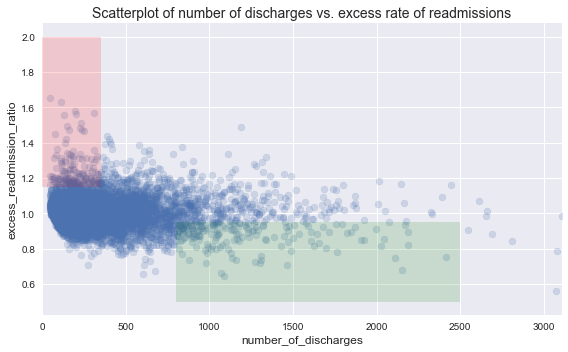

In [282]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function - Series data can work, too
x = clean_hospital_read_df['number_of_discharges'][81:-3]
y = clean_hospital_read_df['excess_readmission_ratio'][81:-3]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('number_of_discharges', fontsize=12)
ax.set_ylabel('excess_readmission_ratio', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

## STATISTICS:HYPOTHESIS TESTING

In [283]:
#null hypothesis : there is not a significant difference in hospitals/facilities with discharges > 1000 and discharges < 100
#alternative :  there is a difference, and that the hospitals with discharges < 100 have a higher readmission rate

In [284]:
low_discharge_df  = clean_hospital_read_df['excess_readmission_ratio'][81:-3].loc[
    clean_hospital_read_df['number_of_discharges'] <= 100]
high_discharge_df = clean_hospital_read_df['excess_readmission_ratio'][81:-3].loc[
    clean_hospital_read_df['number_of_discharges'] >= 1000]
print(low_discharge_df.head())
print(high_discharge_df.head())
print(len(low_discharge_df))
print(len(high_discharge_df))

3579    1.0463
7744    1.1572
5272    1.2088
265     1.0588
1849    1.0188
Name: excess_readmission_ratio, dtype: float64
6799    1.0239
2712    1.1270
8675    0.8816
9236    1.0999
2978    0.7986
Name: excess_readmission_ratio, dtype: float64
611
317


In [285]:
low_discharge_df = low_discharge_df.astype(float)
high_discharge_df = high_discharge_df.astype(float)

In [286]:
print('Low Discharge Rate mean and std Readmission Ratio:',np.mean(low_discharge_df), np.std(low_discharge_df))

Low Discharge Rate mean and std Readmission Ratio: 1.028518166939444 0.06510648722013512


In [287]:
print('High Discharge Rate mean and std Readmission Ratio:', np.mean(high_discharge_df), np.std(high_discharge_df))

High Discharge Rate mean and std Readmission Ratio: 0.9903583596214512 0.1225604805355595


In [288]:
# t-test
t, p = stats.ttest_ind(low_discharge_df, high_discharge_df, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = 5.16978  p = 3.66833e-07


In [289]:
# Effect Size
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d
CohenEffectSize(low_discharge_df, high_discharge_df)

0.42817262028323105

In [290]:
# Code for calculating overlap and superiority between two groups
import scipy.stats
def overlap_superiority(control, treatment, n=1000):
    """Estimates overlap and superiority based on a sample.
    
    control: scipy.stats rv object
    treatment: scipy.stats rv object
    n: sample size
    """
    control_sample = control
    treatment_sample = treatment
    thresh = (control.mean() + treatment.mean()) / 2
    
    control_above = sum(control_sample > thresh)
    treatment_below = sum(treatment_sample < thresh)
    overlap = (control_above + treatment_below) / n
    
    superiority = sum(x > y for x, y in zip(treatment_sample, control_sample)) / n
    return overlap, superiority
overlap_superiority(low_discharge_df, high_discharge_df, n=461)

(1.193058568329718, 0.23427331887201736)

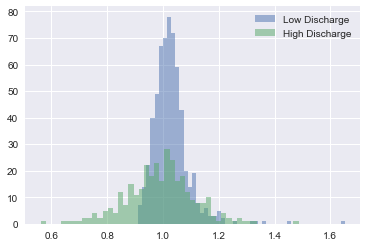

In [291]:
plt.hist(low_discharge_df, bins=50, alpha=0.5, label='Low Discharge')
plt.hist(high_discharge_df, bins=50, alpha=0.5, label='High Discharge')
plt.legend(loc='upper right')
plt.show()

#### there's a difference and a noticeable effect size, but the point at which to separate high and low readmission rates by discharge rate is so arbitrary that there is a need to have a less subjective metric. Let's just look at a correlation matrix that uses the pearson correlation coefficient.

In [292]:
clean_hospital_read_df.drop(['footnote'],axis=1,inplace=True)

In [293]:
import seaborn as sns

In [294]:
clean_hospital_read_df.corr(method='pearson', min_periods=1)

,excess_readmission_ratio,expected_readmission_rate,number_of_discharges,number_of_readmissions,predicted_readmission_rate,provider_number
excess_readmission_ratio,1.000000,-0.039604,-0.088772,0.120906,0.193021,-0.050129
expected_readmission_rate,-0.039604,1.000000,-0.131298,0.314449,0.965176,0.010077
number_of_discharges,-0.088772,-0.131298,1.000000,0.801896,-0.132149,-0.033343
number_of_readmissions,0.120906,0.314449,0.801896,1.000000,0.347994,-0.029219
predicted_readmission_rate,0.193021,0.965176,-0.132149,0.347994,1.000000,-0.006623
provider_number,-0.050129,0.010077,-0.033343,-0.029219,-0.006623,1.000000


In [295]:
clean_hospital_read_df.head(2)

,end_date,excess_readmission_ratio,expected_readmission_rate,hospital_name,measure_name,number_of_discharges,number_of_readmissions,predicted_readmission_rate,provider_number,start_date,state
3654,30-JUN-16,NaN,NaN,HARMON HOSPITAL,READM-30-PN-HRRP,0.0,NaN,NaN,290042.0,01-JUL-13,NV
777,30-JUN-16,NaN,NaN,BROADLAWNS MEDICAL CENTER,READM-30-AMI-HRRP,0.0,NaN,NaN,160101.0,01-JUL-13,IA


In [296]:
clean_hospital_read_df['expected_readmission_rate'].dtype

dtype('float64')

In [298]:
float_dataframe=clean_hospital_read_df.loc[:,clean_hospital_read_df.dtypes==float]

In [299]:
clean_hospital_read_df.corr(method='spearman')

,excess_readmission_ratio,expected_readmission_rate,number_of_discharges,number_of_readmissions,predicted_readmission_rate,provider_number
excess_readmission_ratio,1.000000,0.036165,-0.084439,0.131931,0.345724,-0.059953
expected_readmission_rate,0.036165,1.000000,-0.024878,0.391516,0.929720,0.010747
number_of_discharges,-0.084439,-0.024878,1.000000,0.809008,-0.047436,-0.022764
number_of_readmissions,0.131931,0.391516,0.809008,1.000000,0.421614,-0.032127
predicted_readmission_rate,0.345724,0.929720,-0.047436,0.421614,1.000000,-0.013012
provider_number,-0.059953,0.010747,-0.022764,-0.032127,-0.013012,1.000000


C:\Users\ankitkt\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


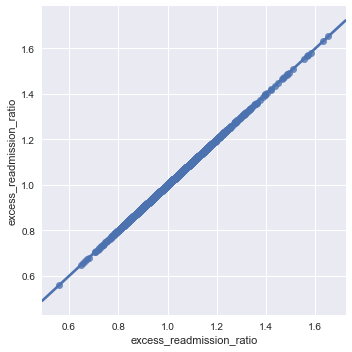

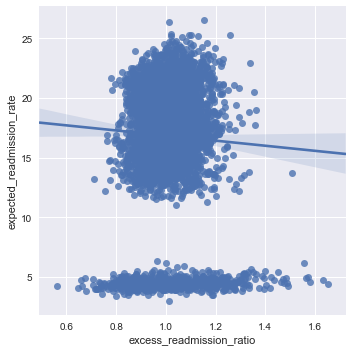

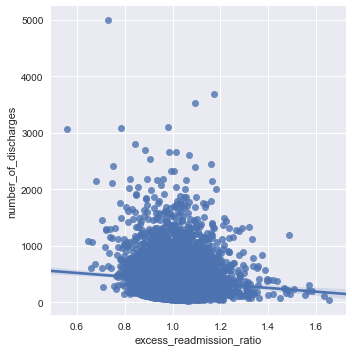

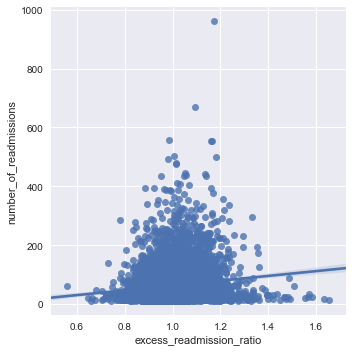

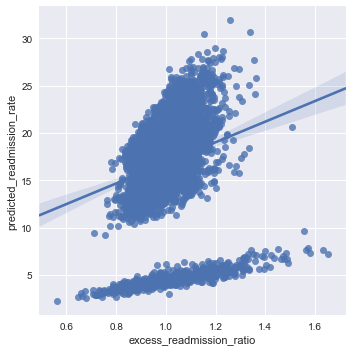

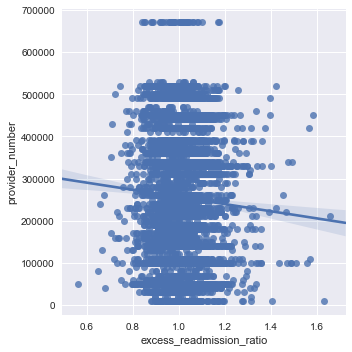

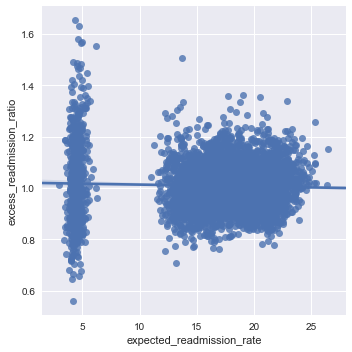

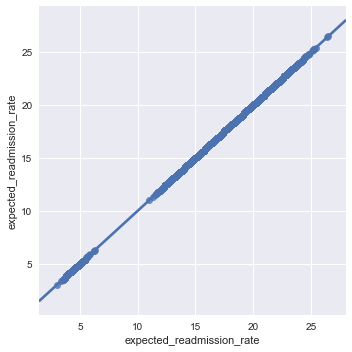

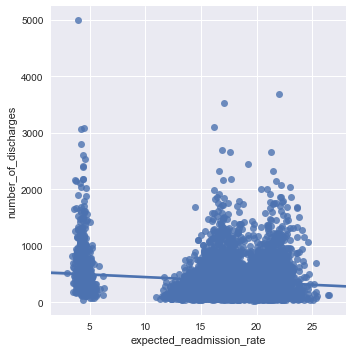

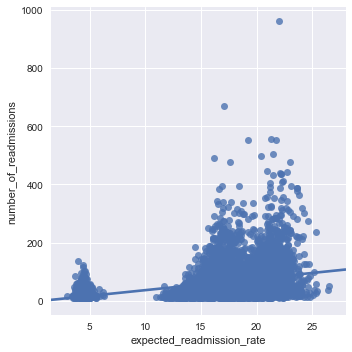

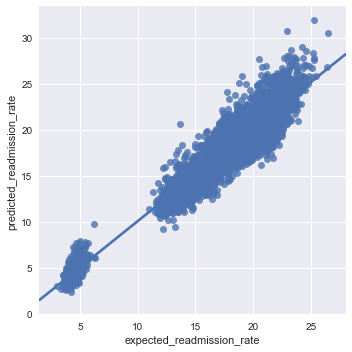

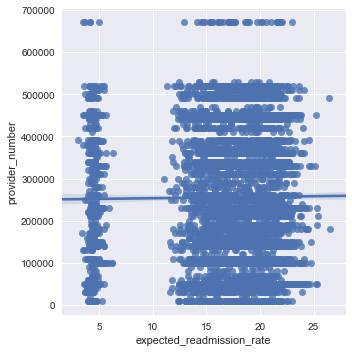

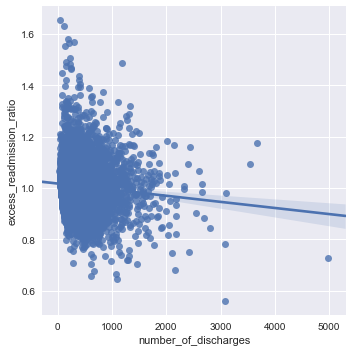

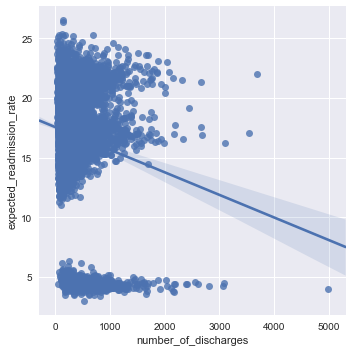

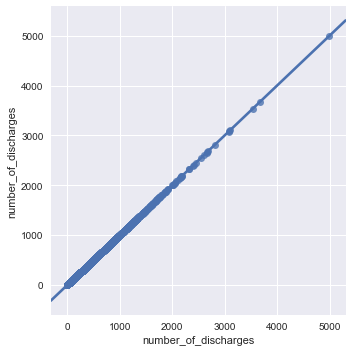

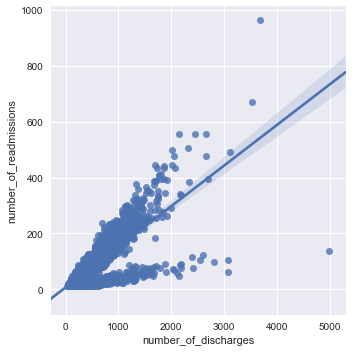

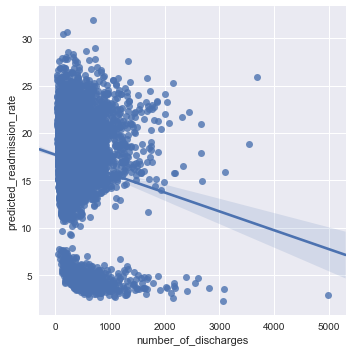

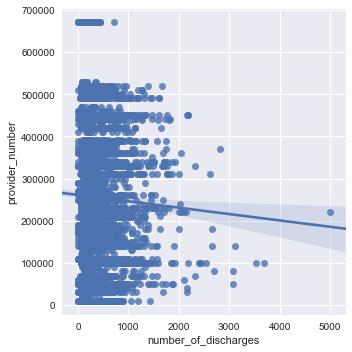

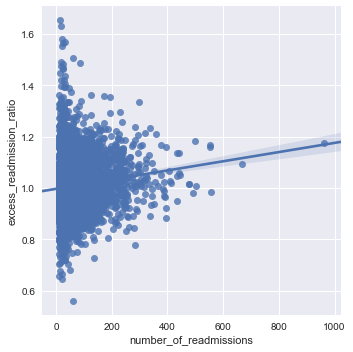

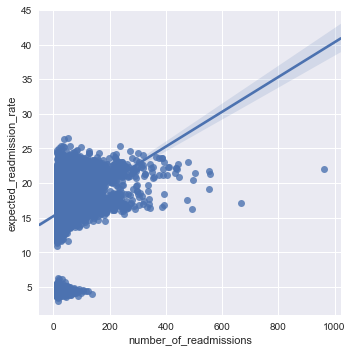

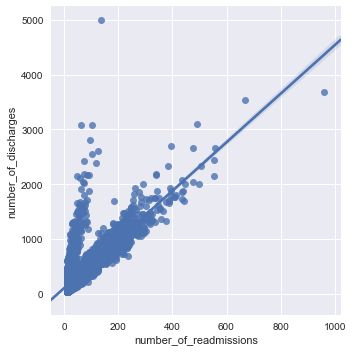

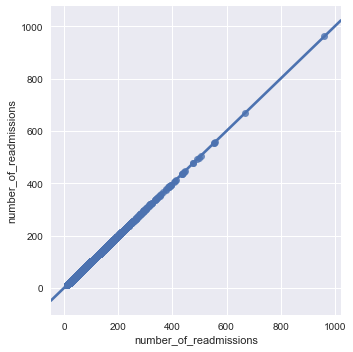

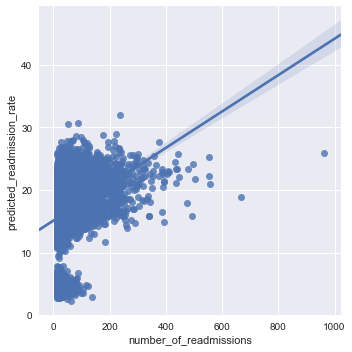

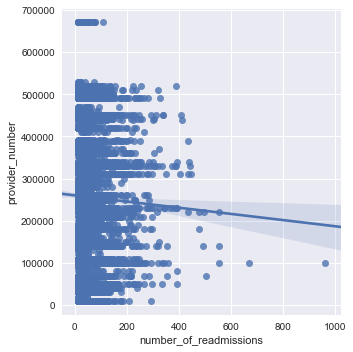

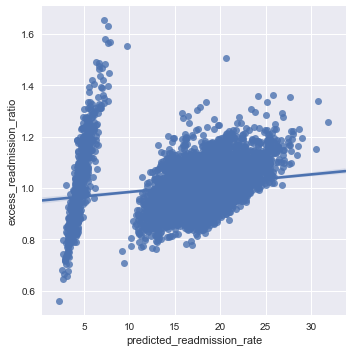

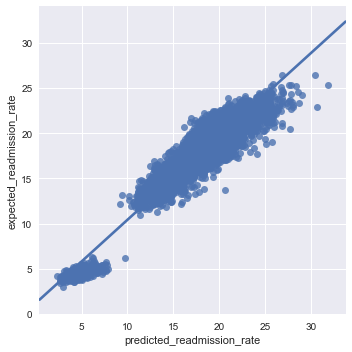

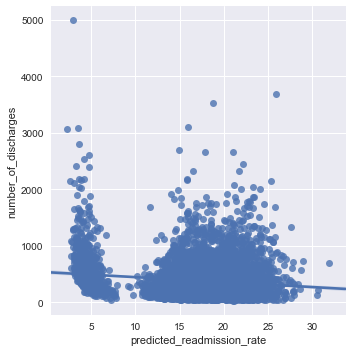

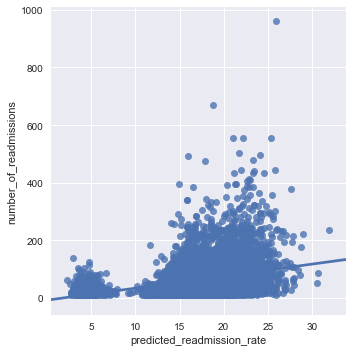

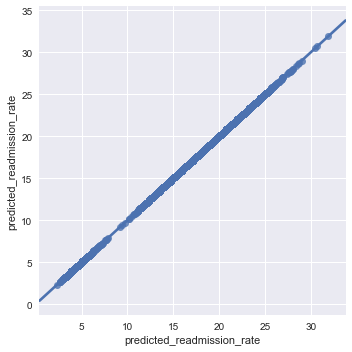

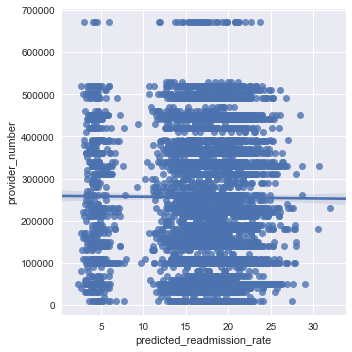

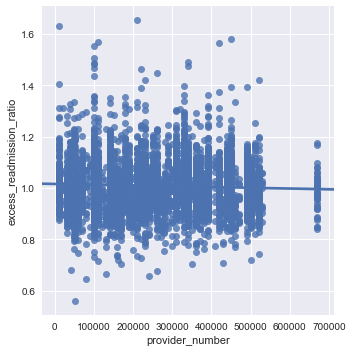

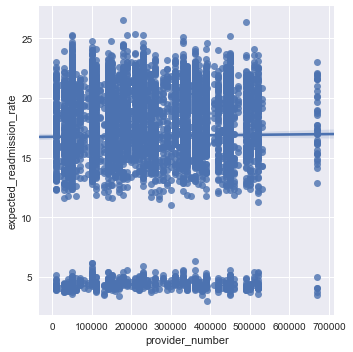

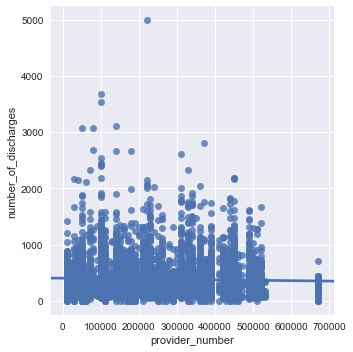

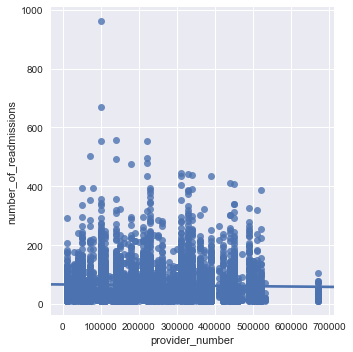

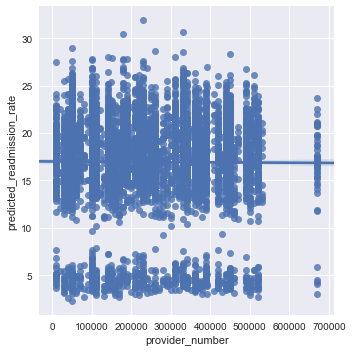

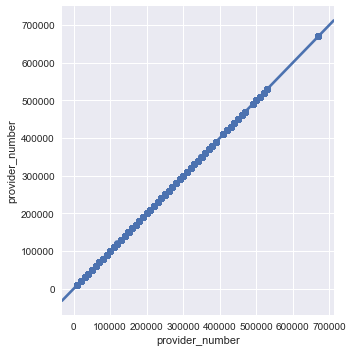

In [300]:
for x in float_dataframe.columns:
    for y in float_dataframe.columns:
        sns.lmplot(x=x,y=y,data=clean_hospital_read_df,fit_reg=True)

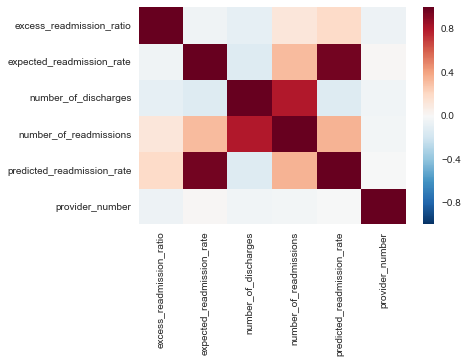

In [301]:
sns.heatmap(clean_hospital_read_df.corr())

In [ ]:
##There is a significant correlation between hospital capacity (number of discharges) and readmission rates.
##Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.